In [1]:
import torch
import onnx
import onnxruntime as ort
import numpy as np
from tqdm.auto import tqdm
import json
from numpyencoder import NumpyEncoder
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [2]:
# Global Configs
DELTA = 0.99
NET_PATH = "./64x4_scratch.onnx"
DATA = torch.load("./dataset/training.pt")
EXPT_NAME = "64x4_scratch_d99"
LAYERS = 4
NEURONS_WIDTH = 64

In [3]:
# Data preprocessing

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.,), (1.,))
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=50000, shuffle=False)

imgs, labels = next(iter(trainloader))

In [6]:
# Modifying model to get neuron activations

model = onnx.load(NET_PATH)

def add_intermediate_outputs(model):
    graph = model.graph
    for node in graph.node:
        if node.op_type == "Relu":
            for output in node.output:
                intermediate_value_info = onnx.helper.make_tensor_value_info(output, onnx.TensorProto.FLOAT, None)
                graph.output.append(intermediate_value_info)
    return model

modified_model = add_intermediate_outputs(model)

modified_model_path = f'{NET_PATH.split(".")[1][1:]}_modified.onnx'
onnx.save(modified_model, modified_model_path)


Node name: /2/Relu
Node name: /4/Relu
Node name: /6/Relu
Node name: /8/Relu


In [14]:
# Setting up inference in onnx

session = ort.InferenceSession(modified_model_path)
input_name = session.get_inputs()[0].name

In [15]:
# Going through each label
P = {
    'config':
    {
        'net': NET_PATH,
        'delta': DELTA,
        'data_len': DATA[1].shape[0]
    }
}

In [16]:
for label in range(10):
    # Filetering relevant data alone
    mask = (labels == label).numpy()
    S = imgs[mask]

    # Initializing a counter
    count = np.zeros((4, 64))

    # Counting across relevant data
    print(f"Processing label {label}...")

    for example in tqdm(S):
        outputs = session.run(None, {input_name: example.numpy().reshape(1, 1, 28, 28)})
        neuron_activations = np.concatenate(outputs[1:])
        whether_activated = neuron_activations > 0
        count += whether_activated

    # Adding neuron indices in A or D based on whether their fr (frequency ratio) is greater than or lesser than delta
    fr = count / S.shape[0]
    greater_than_delta = np.where(fr>=DELTA)
    lesser_than_delta = np.where(fr<(1-DELTA))
    A = list(zip(greater_than_delta[0], greater_than_delta[1]))
    D = list(zip(lesser_than_delta[0], lesser_than_delta[1]))
    
    P[label] = {
        "A":
        {
            "len": len(A),
            "indices": A
        },
        "D": {
            "len": len(D),
            "indices": D
        }
    }

Processing label 0...


  0%|          | 0/4932 [00:00<?, ?it/s]

Processing label 1...


  0%|          | 0/5678 [00:00<?, ?it/s]

Processing label 2...


  0%|          | 0/4968 [00:00<?, ?it/s]

Processing label 3...


  0%|          | 0/5101 [00:00<?, ?it/s]

Processing label 4...


  0%|          | 0/4859 [00:00<?, ?it/s]

Processing label 5...


  0%|          | 0/4506 [00:00<?, ?it/s]

Processing label 6...


  0%|          | 0/4951 [00:00<?, ?it/s]

Processing label 7...


  0%|          | 0/5175 [00:00<?, ?it/s]

Processing label 8...


  0%|          | 0/4842 [00:00<?, ?it/s]

Processing label 9...


  0%|          | 0/4988 [00:00<?, ?it/s]

In [17]:
# Writing it out into a file

with open(f"./NAPs/{EXPT_NAME}.json", "w") as f:
    json.dump(P, f, cls=NumpyEncoder)

In [18]:
# Getting global heatmap

global_count = np.zeros((LAYERS, 256))

for example in tqdm(imgs):
        outputs = session.run(None, {input_name: example})
        neuron_activations = np.concatenate(outputs[1:])
        whether_activated = neuron_activations > 0
        global_count += whether_activated

NameError: name 'LAYERS' is not defined

In [ ]:
global_count

array([[9.4090e+03, 2.7514e+04, 1.0390e+04, ..., 2.4576e+04, 1.6828e+04,
        1.7754e+04],
       [1.3963e+04, 0.0000e+00, 7.9690e+03, ..., 1.3339e+04, 1.6591e+04,
        6.3980e+03],
       [0.0000e+00, 0.0000e+00, 3.0000e+00, ..., 0.0000e+00, 1.2300e+02,
        1.0000e+00],
       [3.2000e+01, 1.0000e+00, 6.5750e+03, ..., 3.4100e+03, 1.0000e+01,
        4.6260e+03]])

In [ ]:
global_ratio = global_count/60000

In [ ]:
global_ratio

array([[1.56816667e-01, 4.58566667e-01, 1.73166667e-01, ...,
        4.09600000e-01, 2.80466667e-01, 2.95900000e-01],
       [2.32716667e-01, 0.00000000e+00, 1.32816667e-01, ...,
        2.22316667e-01, 2.76516667e-01, 1.06633333e-01],
       [0.00000000e+00, 0.00000000e+00, 5.00000000e-05, ...,
        0.00000000e+00, 2.05000000e-03, 1.66666667e-05],
       [5.33333333e-04, 1.66666667e-05, 1.09583333e-01, ...,
        5.68333333e-02, 1.66666667e-04, 7.71000000e-02]])

In [ ]:
import seaborn as sns

<Axes: >

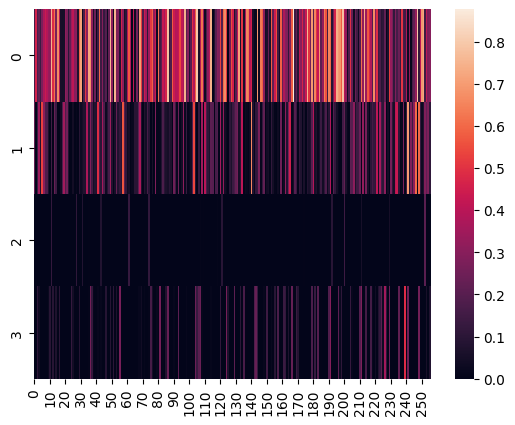

In [ ]:
sns.heatmap(global_ratio)

  0%|          | 0/60000 [00:00<?, ?it/s]

<Axes: >

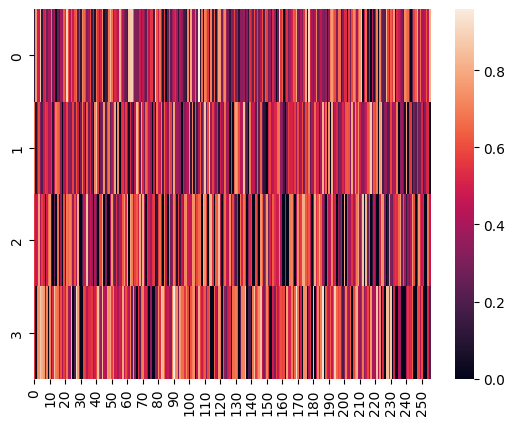

In [ ]:
# Getting global heatmap

global_count = np.zeros((LAYERS, 256))

for example in tqdm(imgs):
        outputs = session.run(None, {input_name: example})
        neuron_activations = np.concatenate(outputs[1:])
        whether_activated = neuron_activations > 0
        global_count += whether_activated
global_count
global_ratio = global_count/60000
global_ratio
import seaborn as sns
sns.heatmap(global_ratio)